## Figures 3 / 4 / 6

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

from pytorch_lightning import utilities as pl_utils
from pytorch_lightning.trainer.trainer import Trainer
from pytorch_lightning.plugins import DDPPlugin
import torch
import pathlib
from functools import partial
import sys, glob
import numpy as np

sys.path.append('..')
sys.path.append('../deep-learning-base')
sys.path.append('../deep-learning-base/training')
sys.path.append('../deep-learning-base/datasets')
sys.path.append('../partially_inverted_reps')

import plot_helper as plt_hp
import output as out
from training import LitProgressBar, NicerModelCheckpointing
import training.finetuning as ft
import architectures as arch
from architectures.callbacks import LightningWrapper, LinearEvalWrapper
from attack.callbacks import AdvCallback
from data_modules import DATA_MODULES
import dataset_metadata as dsmd
from partial_loss import PartialInversionLoss, PartialInversionRegularizedLoss
from __init__ import DATA_PATH_IMAGENET, DATA_PATH, SERVER_PROJECT_PATH

In [41]:
CHECKPOINT_PATHS = {
    'vgg16_bn': {'imagenet': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/vgg16_bn_l2_eps3.ckpt'}},
    'resnet18': {'imagenet': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-18-l2-eps3.ckpt'}},
    'resnet50': {'imagenet': {
        'nonrob': '',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/resnet-50-l2-eps3.ckpt'}},
    'resnet50_mrl': {'imagenet': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl1_e0_ff2048.pt'}},
    'resnet50_ff8': {'imagenet': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff8.pt'}},
    'resnet50_ff16': {'imagenet': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff16.pt'}},
    'resnet50_ff32': {'imagenet': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff32.pt'}},
    'resnet50_ff64': {'imagenet': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff64.pt'}},
    'resnet50_ff128': {'imagenet': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff128.pt'}},
    'resnet50_ff256': {'imagenet': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff256.pt'}},
    'resnet50_ff512': {'imagenet': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff512.pt'}},
    'resnet50_ff1024': {'imagenet': {
        'nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff1024.pt'}},
    'resnet50_ff2048': {'imagenet': {
        'mrl0_nonrob': '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/'\
                  'checkpoints/imagenet1k/r50_mrl0_e0_ff1024.pt'}},
    'wide_resnet50_2': {'imagenet': {
        'nonrob': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                  'robust_imagenet/eps0/wideresnet-50-2-nonrob.ckpt',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/wideresnet-50-2-l2-eps3.ckpt'}},
    'wide_resnet50_4': {'imagenet': {
        'nonrob': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                  'robust_imagenet/eps0/wideresnet-50-4-nonrob.ckpt',
        'robustl2eps3': '/NS/robustness_3/work/vnanda/adv-robustness/logs/'\
                        'robust_imagenet/eps3/wideresnet-50-4-l2-eps3.ckpt'}},
    'vit_small_patch16_224': {
        'imagenet21k': {
            'nonrob': \
                '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
                'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
        'imagenet': {
            'nonrob': \
                '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet1k/'\
                'S_16-i1k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        }
    },
    'vit_small_patch32_224': {
        'imagenet21k': {
            'nonrob': \
                '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet21k/'\
                'S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        },
        'imagenet': {
            'nonrob': \
                '/NS/robustness_2/work/vnanda/invariances_in_reps/deep-learning-base/checkpoints/imagenet1k/'\
                'S_32-i1k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0.npz'
        }
    }
}

In [42]:
MODEL_TO_LAYER_LENGTH = {
    'vgg16_bn': 4096,
    'resnet18': 512,
    'resnet50': 2048,
    'resnet50_mrl': 2048,
    'wide_resnet50_2': 2048,
    'wide_resnet50_4': 2048,
    'vit_small_patch16_224': 384,
    'vit_small_patch32_224': 384
}

In [43]:
SEED = 2
NUM_NODES = 1
DEVICES = 1
BASE_DIR = f"{pathlib.Path('.').parent.resolve()}/checkpoints"

FINETUNE_BS = 256
EVAL_BATCH_SIZE = 100

In [44]:
def save_predictions(model_path, out):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    torch.save({'pred': out[0].detach().cpu(), 'gt': out[2].detach().cpu()}, preds_path)

def load_predictions(model_path):
    preds_path = f'{model_path.split(".ckpt")[0]}.pred'
    if os.path.exists(preds_path):
        return torch.load(preds_path)

def accuracy(gt, pred):
    pred = torch.argmax(pred, 1)
    return torch.sum(gt == pred) / len(gt)

def get_test_acc(model, source_dataset, finetuning_dataset, checkpoint_path, 
                 model_path, seed, fraction, finetune_mode):
    state_dict = torch.load(model_path)
    dm = DATA_MODULES[finetuning_dataset](
        data_dir=DATA_PATH_IMAGENET if 'imagenet' in finetuning_dataset else DATA_PATH,
        transform_train=dsmd.TRAIN_TRANSFORMS_TRANSFER_DEFAULT(224),
        transform_test=dsmd.TEST_TRANSFORMS_DEFAULT(224),
        batch_size=EVAL_BATCH_SIZE)
    dm.init_remaining_attrs(source_dataset)

    ## assign mean and std from source dataset
    m1 = arch.create_model(model, source_dataset, pretrained=True,
                           checkpoint_path=checkpoint_path, seed=SEED, 
                           num_classes=dsmd.DATASET_PARAMS[source_dataset]['num_classes'],
                           callback=partial(LightningWrapper, 
                                            dataset_name=source_dataset,
                                            inference_kwargs={'with_latent': True}),
                           loading_function_kwargs={'strict': False}) # some final layers are strange
    new_layer = ft.setup_model_for_finetuning(
        m1.model, 
        dsmd.DATASET_PARAMS[finetuning_dataset]['num_classes'],
        finetune_mode, fraction, seed)
    new_layer.linear.load_state_dict({k.split('.')[-1]:v \
                                  for k,v in state_dict['state_dict'].items()}, strict=True)
    if hasattr(new_layer, 'neuron_indices') and 'neuron_indices' in state_dict:
        assert torch.all(new_layer.neuron_indices == state_dict['neuron_indices'])
    pl_utils.seed.seed_everything(seed, workers=True)

    trainer = Trainer(accelerator='gpu', 
                      devices=DEVICES,
                      num_nodes=NUM_NODES,
                      log_every_n_steps=1,
                      auto_select_gpus=True, 
                      deterministic=True,
                      check_val_every_n_epoch=1,
                      num_sanity_val_steps=0,
                      callbacks=[
                        LitProgressBar(['loss', 
                                        'running_test_acc'])])

    out = trainer.predict(m1, dataloaders=[dm.test_dataloader()])
    save_predictions(model_path, out)
    gt, pred = out[2], out[0]
    return accuracy(gt, pred)

In [48]:
def results(models_to_compare, source_datasets, finetune_modes, ft_ds, FRACTIONS_OR_NUMBERS, analysis_type):
    plt_str = '== Finetuning results ==\n\n'
    model_to_fracwise_accs = {}
    model_keys = []
    for idx, model in enumerate(models_to_compare):
        for source_dataset in source_datasets:
            for append in CHECKPOINT_PATHS[model][source_dataset].keys():
                for finetune_mode in finetune_modes:
                    print (f'{model}-{append}-{source_dataset}-{finetune_mode}')
                    frac_wise_test_accs = {}
                    if FRACTIONS_OR_NUMBERS[idx] is None:
                        PARTIAL_FRACTIONS = sorted(
                            list(set(
                                [float(x.split('/frac-')[1].split('-')[0]) for x in \
                                        glob.glob(f'./checkpoints/{model}-base-'
                                                  f'{source_dataset}-ft-{ft_ds}/'
                                                  f'*-bs-256-{append}/*-topk=1.ckpt') \
                                 if len(x.split('/frac-')[1].split('-')[0]) == 7 and \
                                    'layer' not in x.split('/')[-1] and \
                                    'pool' not in x.split('/')[-1] and \
                                    'full-feature' not in x.split('/')[-1]]
                            )))
                        FRACTIONS_OR_NUMBERS[idx] = PARTIAL_FRACTIONS
                    else:
                        PARTIAL_FRACTIONS = FRACTIONS_OR_NUMBERS[idx]

                    for frac in PARTIAL_FRACTIONS:
                        if isinstance(frac, int):
                            actual_fraction = frac / PARTIAL_FRACTIONS[-1]
                        else:
                            actual_fraction = frac
                        model_paths = [x for x in glob.glob(
                            f'{BASE_DIR}/{model}-base-{source_dataset}-ft-{ft_ds}/'
                            f'frac-{actual_fraction:.5f}-mode-{finetune_mode}-seed-*-'
                            f'ftmode-linear-lr-*-bs*-{append}/*-topk=1.ckpt') \
                                       if 'layer' not in x.split('/')[-1] and \
                                          'pool' not in x.split('/')[-1] and \
                                          'full-feature' not in x.split('/')[-1]]
                        print (f'{frac}: {len(model_paths)}')
                        for path in model_paths:
                            pickled_preds = load_predictions(path)
                            if pickled_preds is not None:
                                acc = accuracy(pickled_preds['gt'], pickled_preds['pred']).item()
                            else:
                                acc = get_test_acc(model, source_dataset, ft_ds, 
                                                   CHECKPOINT_PATHS[model][source_dataset][append], path, 
                                                   int(path.split('-seed-')[1].split('-')[0]), 
                                                   actual_fraction, finetune_mode).item()
                            if actual_fraction in frac_wise_test_accs:
                                frac_wise_test_accs[actual_fraction].append(acc)
                            else:
                                frac_wise_test_accs[actual_fraction] = [acc]
                    if len(frac_wise_test_accs) > 0:
                        model_keys.append(f'{model}-{append}-{source_dataset}-{finetune_mode}')
                        model_to_fracwise_accs[f'{model}-{append}-{source_dataset}-{finetune_mode}'] = \
                            frac_wise_test_accs

    x_vals_fracs = [sorted(list(model_to_fracwise_accs[mkey].keys())) for mkey in model_keys]
    x_vals_nums = [[int(f*MODEL_TO_LAYER_LENGTH[mkey.split('-')[0]]) for f in fracs] \
                   for mkey, fracs in zip(model_keys, x_vals_fracs)]
    plt_str += '{}\n\n{}\n\n'.format(
        plt_hp.get_wiki_link(plt_hp.line_plot(
            [[np.nanmean(model_to_fracwise_accs[mkey][f]) 
              for f in sorted(model_to_fracwise_accs[mkey].keys())] \
                 for mkey in model_keys], 
            'Fraction of neurons', 'Transfer Accuracy', ft_ds, 
            subfolder=analysis_type, 
            filename=f'{"-".join(models_to_compare)}_{ft_ds}_{append}', 
            extension='png', x_vals=x_vals_fracs, 
            legend_vals=[f"{m.split('-')[0]}-{m.split('-')[1]}-{m.split('-')[3]}" for m in model_keys], 
            vertical_line=None, colors=plt_hp.COLORS, 
            linestyles=['-'] * len(model_keys), 
            y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
            plot_inside=False, legend_location='best', savefig=True, 
            figsize=(10,6), marker=[True] * len(model_keys), 
            results_subfolder_name='archs_loss_datasets', grid_spacing=None, 
            y_err=[[np.nanstd(model_to_fracwise_accs[mkey][f]) \
                    for f in sorted(model_to_fracwise_accs[mkey].keys())] for mkey in model_keys], 
            legend_ncol=4), 
                             SERVER_PROJECT_PATH, size=700),
        plt_hp.get_wiki_link(plt_hp.line_plot(
            [[np.nanmean(model_to_fracwise_accs[mkey][f]) 
              for f in sorted(model_to_fracwise_accs[mkey].keys())] \
                 for mkey in model_keys], 
            'Number of neurons', 'Transfer Accuracy', ft_ds, 
            subfolder=analysis_type, 
            filename=f'{"-".join(models_to_compare)}_{ft_ds}_{append}_numbers', 
            extension='png', x_vals=x_vals_nums, 
            legend_vals=[f"{m.split('-')[0]}-{m.split('-')[1]}-{m.split('-')[3]}" for m in model_keys], 
            vertical_line=None, colors=plt_hp.COLORS, 
            linestyles=['-'] * len(model_keys), 
            y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
            plot_inside=False, legend_location='best', savefig=True, 
            figsize=(10,6), marker=[True] * len(model_keys), 
            results_subfolder_name='archs_loss_datasets', grid_spacing=None, 
            y_err=[[np.nanstd(model_to_fracwise_accs[mkey][f]) \
                    for f in sorted(model_to_fracwise_accs[mkey].keys())] for mkey in model_keys], 
            legend_ncol=4), 
                             SERVER_PROJECT_PATH, size=700)
    )

    with open(f'./results/archs_loss_datasets/{analysis_type}/'
              f'wiki_results-{"-".join(source_datasets)}-{ft_ds}.txt', 'w') as fp:
        fp.write(plt_str)
    out.upload_results(['{}/{}/{}'.format(plt_hp.RESULTS_FOLDER_NAME, 'archs_loss_datasets', analysis_type)], 
        'results', SERVER_PROJECT_PATH, '.png')
    
    return model_to_fracwise_accs

In [49]:
def estimate_dr(fractions, corresponding_accs, delta):
    '''
    fractions: a list of fractions (will be sorted)
    corresponding_accs: a list of lists where each list contains accuracy along multiple random seeds
    delta: what fraction of full layer accuracy do you want from the fraction
    '''
    fractions, corresponding_accs = list(zip(*sorted(zip(fractions, corresponding_accs), 
                                                     key=lambda x: x[0])))
    full_acc = np.mean(corresponding_accs[-1])
    ratios = np.array([])
    for fr, accs in zip(fractions, corresponding_accs):
        ratios = np.append(ratios, np.mean(accs) / full_acc)
    return 1 - fractions[np.argmin(np.abs(ratios - delta))]

### Compare different architectures with both nonrob and rob losses

vgg16_bn-nonrob-imagenet-random
0.0005: 2
0.001: 2
0.005: 2
0.01: 2
0.05: 2
0.1: 2
0.2: 2
0.3: 1
0.5: 1
0.8: 1
0.9: 1
1.0: 1
vgg16_bn-robustl2eps3-imagenet-random
0.0005: 2
0.001: 2
0.005: 2
0.01: 2
0.05: 2
0.1: 2
0.2: 2
0.3: 2
0.5: 2
0.8: 2
0.9: 2
1.0: 1
resnet18-nonrob-imagenet-random
0.005: 5
0.01: 5
0.05: 5
0.1: 5
0.2: 5
0.3: 5
0.5: 5
0.8: 5
0.9: 5
1.0: 1
resnet18-robustl2eps3-imagenet-random
0.005: 5
0.01: 5
0.05: 5
0.1: 5
0.2: 5
0.3: 5
0.5: 5
0.8: 5
0.9: 5
1.0: 1
resnet50-nonrob-imagenet-random
0.0005: 5
0.001: 5
0.002: 5
0.003: 5
0.004: 5
0.005: 5
0.01: 5
0.05: 5
0.1: 5
0.2: 5
0.3: 5
0.5: 5
0.8: 5
0.9: 5
1.0: 1
resnet50-robustl2eps3-imagenet-random
0.0005: 5
0.001: 5
0.002: 5
0.003: 5
0.004: 5
0.005: 5
0.01: 5
0.05: 5
0.1: 30
0.2: 30
0.3: 30
0.5: 5
0.8: 5
0.9: 5
1.0: 1
wide_resnet50_2-nonrob-imagenet-random
0.0005: 5
0.001: 5
0.002: 5
0.003: 5
0.004: 5
0.005: 5
0.01: 5
0.05: 5
0.1: 5
0.2: 5
0.3: 5
0.5: 5
0.8: 5
0.9: 5
1.0: 1
wide_resnet50_2-robustl2eps3-imagenet-random
0.0005: 5

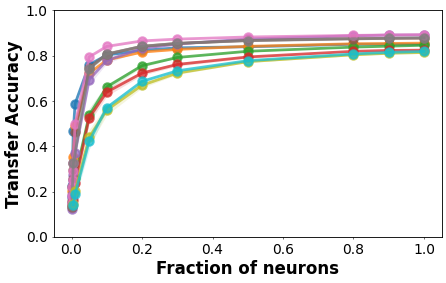

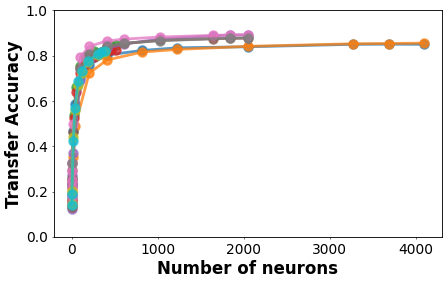

Uploading results in ['results/archs_loss_datasets/architectures'] to contact.mpi-sws.org...
Uploading 5 files to server
copying results/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png
copying results/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png
copying results/archs_loss_datasets/architectures/vgg16_bn_cifar10_robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/a

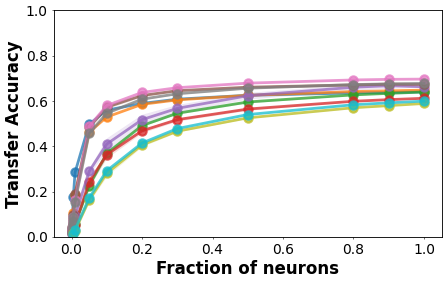

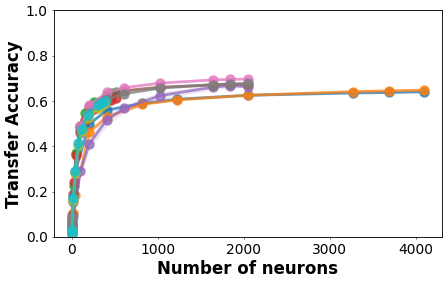

Uploading results in ['results/archs_loss_datasets/architectures'] to contact.mpi-sws.org...
Uploading 5 files to server
copying results/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png
copying results/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png
copying results/archs_loss_datasets/architectures/vgg16_bn_cifar10_robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/a

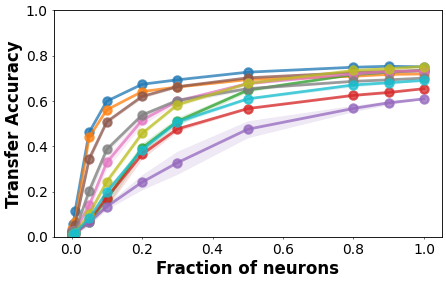

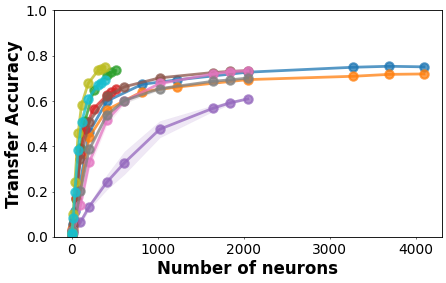

Uploading results in ['results/archs_loss_datasets/architectures'] to contact.mpi-sws.org...
Uploading 5 files to server
copying results/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png
copying results/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png
copying results/archs_loss_datasets/architectures/vgg16_bn_cifar10_robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/a

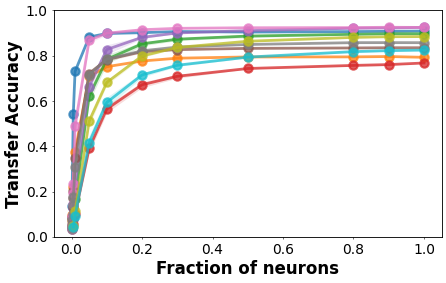

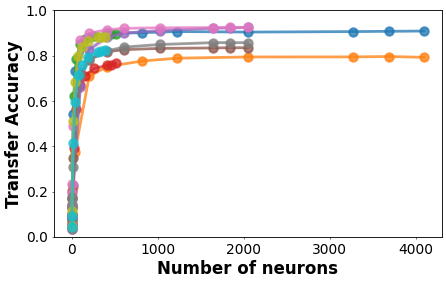

Uploading results in ['results/archs_loss_datasets/architectures'] to contact.mpi-sws.org...
Uploading 5 files to server
copying results/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png
copying results/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/architectures/vgg16_bn-resnet18-resnet50-wide_resnet50_2-vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png
copying results/archs_loss_datasets/architectures/vgg16_bn_cifar10_robustl2eps3.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/a

In [50]:
SOURCE_DATASETS = ['imagenet']
MODELS = ['vgg16_bn', 'resnet18', 'resnet50', 'wide_resnet50_2', 
#           'wide_resnet50_4', 
          'vit_small_patch16_224', 'vit_small_patch32_224']
FINETUNE_MODES = ['random']
FRACTIONS_OR_NUMBERS = [None] * len(MODELS)
ANALYSIS_TYPE = 'architectures'

datasetwise_model_to_accs = {}
for FT_DATASET in ['cifar10','cifar100','flowers','oxford-iiit-pets']:
    datasetwise_model_to_accs[FT_DATASET] = \
        results(MODELS, SOURCE_DATASETS, FINETUNE_MODES, 
                FT_DATASET, FRACTIONS_OR_NUMBERS, ANALYSIS_TYPE)

### $\delta$ ablations

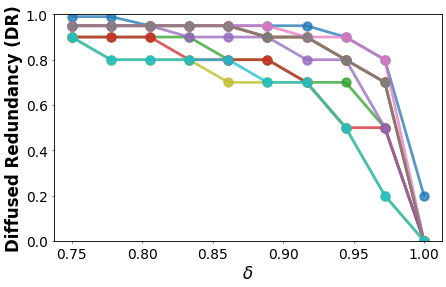

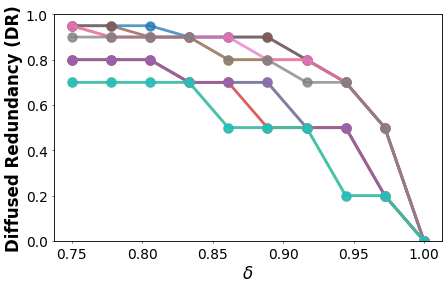

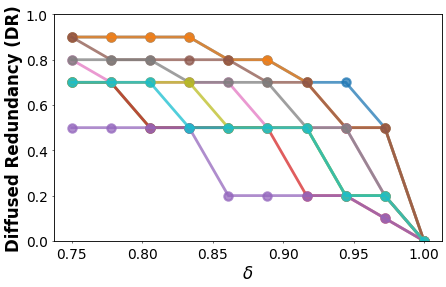

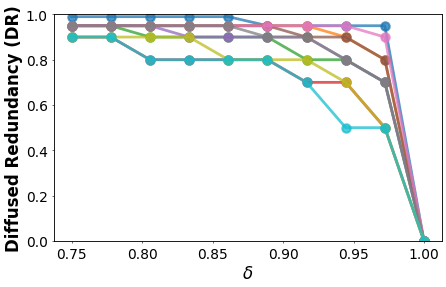

In [33]:
deltas = np.linspace(0.75,1.,10)
for ft_ds in datasetwise_model_to_accs.keys():
    all_dr_vals, all_model_names = [], []
    for model in datasetwise_model_to_accs[ft_ds].keys():
        all_dr_vals.append(
            [estimate_dr(*list(zip(*datasetwise_model_to_accs[ft_ds][model].items())), d) for d in deltas]
        )
        all_model_names.append(f"{model.split('-')[0]}-{model.split('-')[1]}-{model.split('-')[3]}")
    
    plt_hp.line_plot(
        all_dr_vals, r'$\delta$', 'Diffused Redundancy (DR)', ft_ds, 
        subfolder=ANALYSIS_TYPE, filename=f'{"-".join(MODELS)}_{ft_ds}_dr', 
        extension='png', x_vals=[deltas] * len(all_dr_vals), 
        legend_vals=all_model_names, 
        vertical_line=None, colors=plt_hp.COLORS, 
        linestyles=['-'] * len(all_model_names), 
        y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
        plot_inside=False, legend_location='best', savefig=True, 
        figsize=(10,6), marker=[True] * len(all_model_names), 
        results_subfolder_name='archs_loss_datasets', grid_spacing=None, 
        y_err=None, legend_ncol=5)

### Table 1 measures

In [17]:
for ft_ds in ['cifar10','cifar100','flowers','oxford-iiit-pets']:
    for model in MODELS:
        dr = estimate_dr(
            *list(zip(*datasetwise_model_to_accs[ft_ds][f'{model}-nonrob-imagenet-random'].items())), 0.9)
        print (f'{ft_ds}, {model}, {dr}')

cifar10, vgg16_bn, 0.95
cifar10, resnet18, 0.8
cifar10, resnet50, 0.9
cifar10, wide_resnet50_2, 0.95
cifar10, vit_small_patch16_224, 0.7
cifar10, vit_small_patch32_224, 0.7
cifar100, vgg16_bn, 0.8
cifar100, resnet18, 0.5
cifar100, resnet50, 0.5
cifar100, wide_resnet50_2, 0.8
cifar100, vit_small_patch16_224, 0.5
cifar100, vit_small_patch32_224, 0.5
flowers, vgg16_bn, 0.8
flowers, resnet18, 0.5
flowers, resnet50, 0.19999999999999996
flowers, wide_resnet50_2, 0.5
flowers, vit_small_patch16_224, 0.5
flowers, vit_small_patch32_224, 0.5
oxford-iiit-pets, vgg16_bn, 0.95
oxford-iiit-pets, resnet18, 0.9
oxford-iiit-pets, resnet50, 0.9
oxford-iiit-pets, wide_resnet50_2, 0.95
oxford-iiit-pets, vit_small_patch16_224, 0.8
oxford-iiit-pets, vit_small_patch32_224, 0.7


### Compare different upstream training datasets

vit_small_patch16_224-nonrob-imagenet-random
0.005: 5
0.01: 5
0.05: 5
0.1: 5
0.2: 5
0.3: 5
0.5: 5
0.8: 5
0.9: 5
1.0: 1
vit_small_patch16_224-nonrob-imagenet21k-random
0.005: 9
0.01: 0
0.05: 9
0.1: 9
0.2: 9
0.3: 0
0.5: 9
0.8: 0
0.9: 8
1.0: 1
vit_small_patch32_224-nonrob-imagenet-random
0.005: 5
0.01: 5
0.05: 5
0.1: 5
0.2: 5
0.3: 5
0.5: 5
0.8: 5
0.9: 5
1.0: 1
vit_small_patch32_224-nonrob-imagenet21k-random
0.005: 10
0.01: 0
0.05: 10
0.1: 10
0.2: 10
0.3: 0
0.5: 10
0.8: 0
0.9: 10
1.0: 1


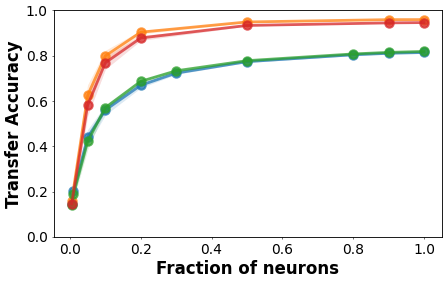

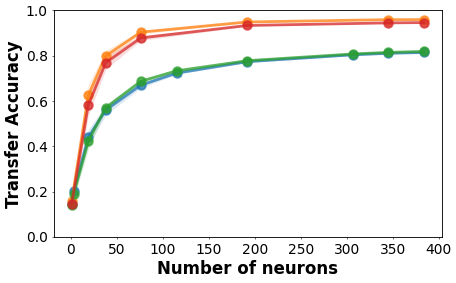

Uploading results in ['results/archs_loss_datasets/upstream_datasets'] to contact.mpi-sws.org...
Uploading 4 files to server
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_flowers_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_flowers_nonrob.png
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png
copying results/archs_loss_datasets/ups

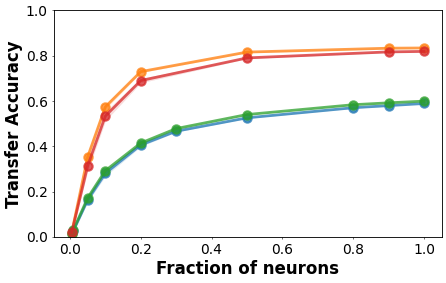

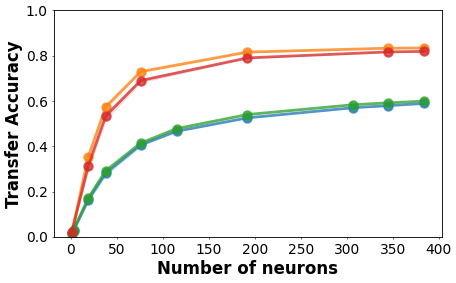

Uploading results in ['results/archs_loss_datasets/upstream_datasets'] to contact.mpi-sws.org...
Uploading 4 files to server
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_flowers_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_flowers_nonrob.png
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png
copying results/archs_loss_datasets/ups

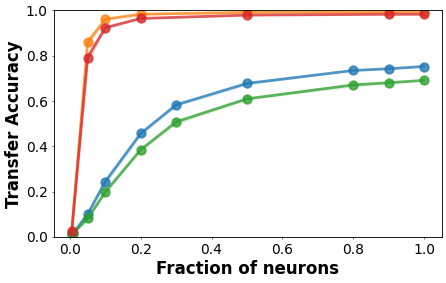

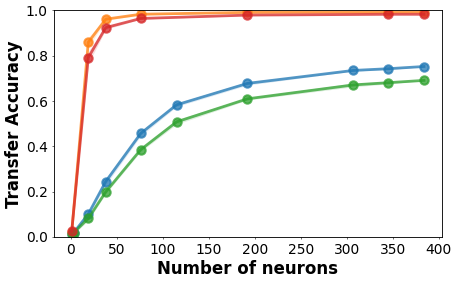

Uploading results in ['results/archs_loss_datasets/upstream_datasets'] to contact.mpi-sws.org...
Uploading 4 files to server
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_flowers_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_flowers_nonrob.png
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png
copying results/archs_loss_datasets/ups

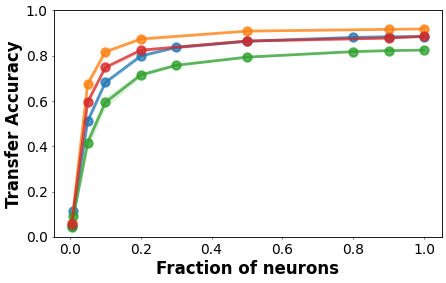

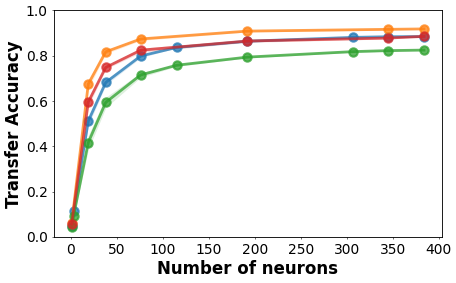

Uploading results in ['results/archs_loss_datasets/upstream_datasets'] to contact.mpi-sws.org...
Uploading 4 files to server
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_flowers_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_flowers_nonrob.png
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar100_nonrob.png
copying results/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/upstream_datasets/vit_small_patch16_224-vit_small_patch32_224_cifar10_nonrob.png
copying results/archs_loss_datasets/ups

In [51]:
SOURCE_DATASETS = ['imagenet', 'imagenet21k']
MODELS = ['vit_small_patch16_224', 'vit_small_patch32_224']
FINETUNE_MODES = ['random']
FRACTIONS_OR_NUMBERS = [None] * len(MODELS)
ANALYSIS_TYPE = 'upstream_datasets'

datasetwise_model_to_accs = {}
for FT_DATASET in ['cifar10','cifar100','flowers','oxford-iiit-pets']:
    datasetwise_model_to_accs[FT_DATASET] = \
        results(MODELS, SOURCE_DATASETS, FINETUNE_MODES, 
                FT_DATASET, FRACTIONS_OR_NUMBERS, ANALYSIS_TYPE)

### $\delta$ ablations

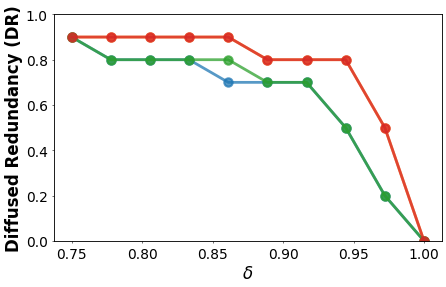

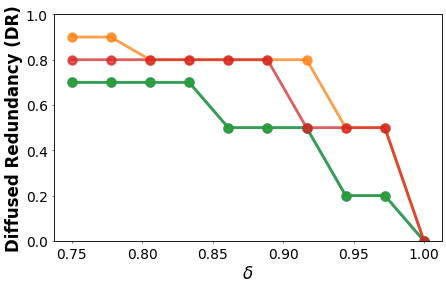

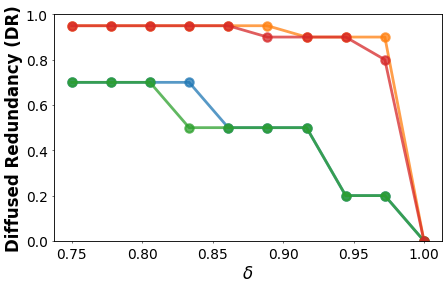

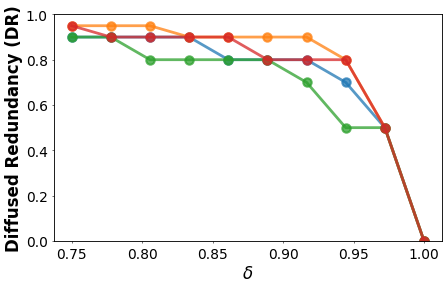

In [37]:
deltas = np.linspace(0.75,1.,10)
for ft_ds in datasetwise_model_to_accs.keys():
    all_dr_vals, all_model_names = [], []
    for model in datasetwise_model_to_accs[ft_ds].keys():
        all_dr_vals.append(
            [estimate_dr(*list(zip(*datasetwise_model_to_accs[ft_ds][model].items())), d) for d in deltas]
        )
        all_model_names.append(f"{model.split('-')[0]}-{model.split('-')[1]}-{model.split('-')[3]}")
    
    plt_hp.line_plot(
        all_dr_vals, r'$\delta$', 'Diffused Redundancy (DR)', ft_ds, 
        subfolder=ANALYSIS_TYPE, filename=f'{"-".join(MODELS)}_{ft_ds}_dr', 
        extension='png', x_vals=[deltas] * len(all_dr_vals), 
        legend_vals=all_model_names, 
        vertical_line=None, colors=plt_hp.COLORS, 
        linestyles=['-'] * len(all_model_names), 
        y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
        plot_inside=False, legend_location='best', savefig=True, 
        figsize=(10,6), marker=[True] * len(all_model_names), 
        results_subfolder_name='archs_loss_datasets', grid_spacing=None, 
        y_err=None, legend_ncol=2)

### Compare ResNet50-MRL to ResNet50-nonrob to ResNet50-rob

resnet50-nonrob-imagenet-random
0.0005: 5
0.001: 5
0.002: 5
0.003: 5
0.004: 5
0.005: 5
0.01: 5
0.05: 5
0.1: 5
0.2: 5
0.3: 5
0.5: 5
0.8: 5
0.9: 5
1.0: 1
resnet50-nonrob-imagenet-first
0.0005: 0
0.001: 0
0.002: 0
0.003: 0
0.004: 0
0.005: 0
0.01: 0
0.05: 0
0.1: 0
0.2: 0
0.3: 0
0.5: 0
0.8: 0
0.9: 0
1.0: 0
resnet50-robustl2eps3-imagenet-random
0.0005: 5
0.001: 5
0.002: 5
0.003: 5
0.004: 5
0.005: 5
0.01: 5
0.05: 5
0.1: 30
0.2: 30
0.3: 30
0.5: 5
0.8: 5
0.9: 5
1.0: 1
resnet50-robustl2eps3-imagenet-first
0.0005: 0
0.001: 0
0.002: 0
0.003: 0
0.004: 0
0.005: 0
0.01: 0
0.05: 0
0.1: 0
0.2: 0
0.3: 0
0.5: 0
0.8: 0
0.9: 0
1.0: 0
resnet50_mrl-nonrob-imagenet-random
8: 5
16: 5
32: 5
64: 5
128: 5
256: 5
512: 5
1024: 5
2048: 1
resnet50_mrl-nonrob-imagenet-first
8: 1
16: 1
32: 1
64: 1
128: 1
256: 1
512: 1
1024: 1
2048: 1


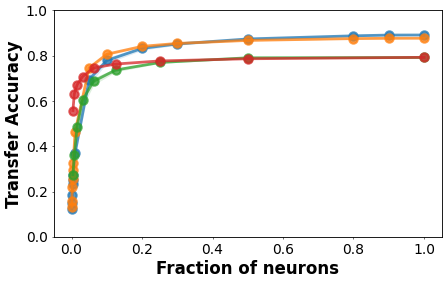

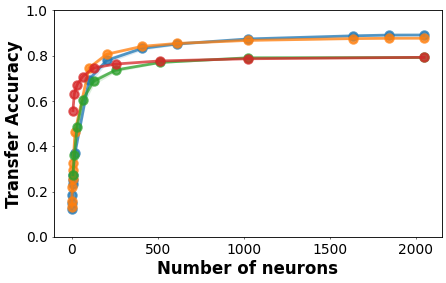

Uploading results in ['results/archs_loss_datasets/efficient_representations'] to contact.mpi-sws.org...
Uploading 8 files to server
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_cifar10_mrl0_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_cifar10_mrl0_nonrob.png
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_flowers_mrl0_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_flowers_mrl0_nonrob.png
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl_cifar100_nonrob.png
copying results/archs_loss_data

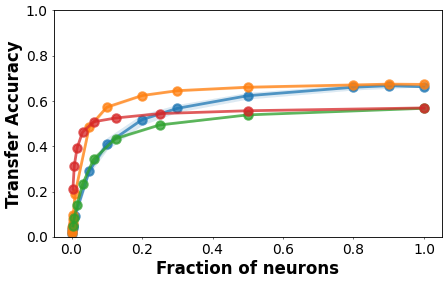

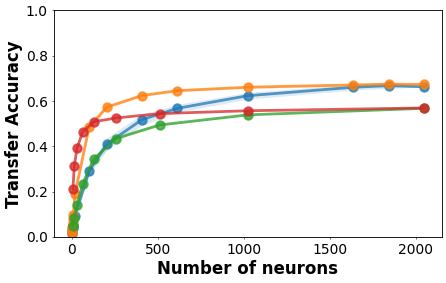

Uploading results in ['results/archs_loss_datasets/efficient_representations'] to contact.mpi-sws.org...
Uploading 8 files to server
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_cifar10_mrl0_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_cifar10_mrl0_nonrob.png
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_flowers_mrl0_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_flowers_mrl0_nonrob.png
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl_cifar100_nonrob.png
copying results/archs_loss_data

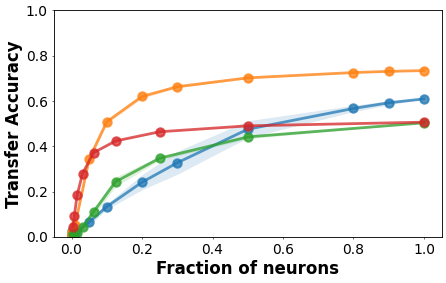

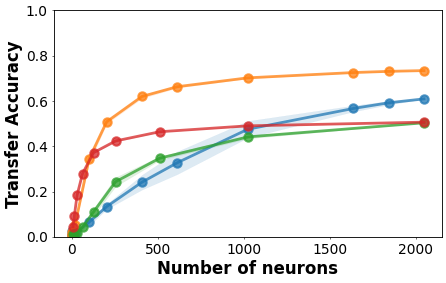

Uploading results in ['results/archs_loss_datasets/efficient_representations'] to contact.mpi-sws.org...
Uploading 8 files to server
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_cifar10_mrl0_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_cifar10_mrl0_nonrob.png
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_flowers_mrl0_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_flowers_mrl0_nonrob.png
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl_cifar100_nonrob.png
copying results/archs_loss_data

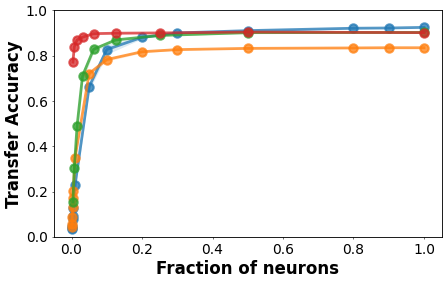

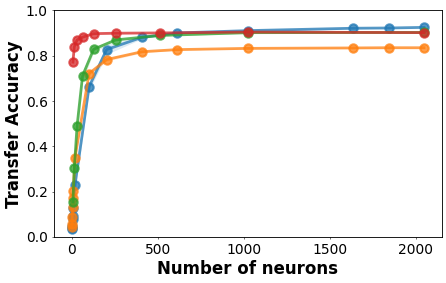

Uploading results in ['results/archs_loss_datasets/efficient_representations'] to contact.mpi-sws.org...
Uploading 8 files to server
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_cifar10_mrl0_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_cifar10_mrl0_nonrob.png
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_flowers_mrl0_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl-resnet50_ff2048_flowers_mrl0_nonrob.png
copying results/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl_cifar100_nonrob.png to /home/vnanda/public_html/results/partially_inverted_reps/archs_loss_datasets/efficient_representations/resnet50-resnet50_mrl_cifar100_nonrob.png
copying results/archs_loss_data

In [52]:
SOURCE_DATASETS = ['imagenet']
MODELS = ['resnet50', 'resnet50_mrl']
FINETUNE_MODES = ['random', 'first']
FRACTIONS_OR_NUMBERS = [None, [8,16,32,64,128,256,512,1024,2048]]
ANALYSIS_TYPE = 'efficient_representations'

datasetwise_model_to_accs = {}
for FT_DATASET in ['cifar10','cifar100','flowers','oxford-iiit-pets']:
    datasetwise_model_to_accs[FT_DATASET] = \
        results(MODELS, SOURCE_DATASETS, FINETUNE_MODES, 
                FT_DATASET, FRACTIONS_OR_NUMBERS, ANALYSIS_TYPE)

### $\delta$ ablations

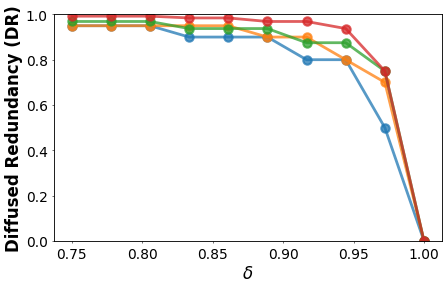

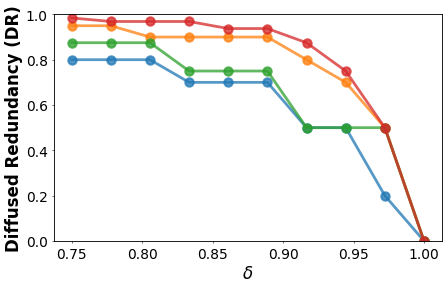

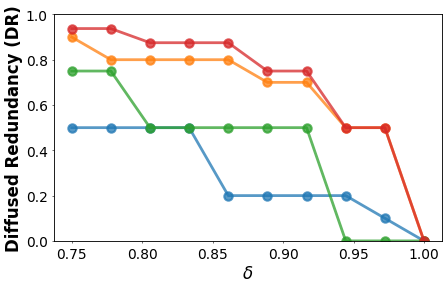

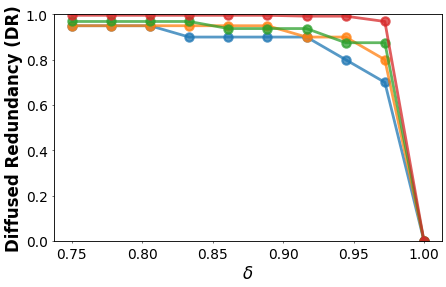

In [39]:
deltas = np.linspace(0.75,1.,10)
for ft_ds in datasetwise_model_to_accs.keys():
    all_dr_vals, all_model_names = [], []
    for model in datasetwise_model_to_accs[ft_ds].keys():
        all_dr_vals.append(
            [estimate_dr(*list(zip(*datasetwise_model_to_accs[ft_ds][model].items())), d) for d in deltas]
        )
        all_model_names.append(f"{model.split('-')[0]}-{model.split('-')[1]}-{model.split('-')[3]}")
    
    plt_hp.line_plot(
        all_dr_vals, r'$\delta$', 'Diffused Redundancy (DR)', ft_ds, 
        subfolder=ANALYSIS_TYPE, filename=f'{"-".join(MODELS)}_{ft_ds}_dr', 
        extension='png', x_vals=[deltas] * len(all_dr_vals), 
        legend_vals=all_model_names, 
        vertical_line=None, colors=plt_hp.COLORS, 
        linestyles=['-'] * len(all_model_names), 
        y_lims=(0.,1.), root_dir='.', paper_friendly_plots=True, 
        plot_inside=False, legend_location='best', savefig=True, 
        figsize=(10,6), marker=[True] * len(all_model_names), 
        results_subfolder_name='archs_loss_datasets', grid_spacing=None, 
        y_err=None, legend_ncol=2)